Optimizing Models with Cross-Validation
===

Author: Nathan A. Mahynski

Date: 2023/09/07

Description: Introduction to different types of cross-validation strategies, when to use them, and important differences.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/learn/cv_optimization.ipynb)

[Cross-validation (CV)](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is used to estimate the generalization error of a model, that is, how well it performs on unseen data. To be accurate, we must avoid testing on data used during model training since the model will be biased to fit that data. Any estimate of model performance using training data will be overly optimistic; however, it is not always clear by how much, and the scarcity of data often drives one to make assumptions that allow this data to be re-used. Various methods of CV exist to balance the amount of effort expended and assumptions made to obtain this estimate.

CV is also critical to selecting optimal model hyperparameters so that the final model will perform as well as possible when deployed in real-world settings.

Scikit-learn has a nice discussion available [here](https://scikit-learn.org/stable/modules/cross_validation.html) along with illustrations of the different CV splittings.

Image credit throughout, unless otherwise stated, goes to [Python Machine Learning, 3rd Ed.](https://github.com/rasbt/python-machine-learning-book-3rd-edition/) by Raschka and Mirjalili.

**An important note:**  In the examples below, data will be split randomly using both CV splitter and models. In sklearn the randomness can be controlled by specifying either an integer seed or a `RandomState`; see [here](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness) for a full discussion.  In short, specifying an integer means the data is always split the same way each time the splitter or model is called.  Using a `RandomState` means the data ends up being split differently during subsequent calls to the same splitter.  There are some cases when this can use useful, but if enough data and repeats are performed the results from using an integer (illustrated below) should be similar.  For the sake of reproducibility and ensuring that algorithms being compared are looking at the same data using the tools below, an integer seed is always used.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")
    
import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [44]:
import sklearn
import scipy

import numpy as np

from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from scipy.stats import uniform

from pychemauth.preprocessing.scaling import CorrectedScaler

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.7.2
numpy     : 1.24.4
sklearn   : 1.3.0
json      : 2.0.9
watermark : 2.4.3
pychemauth: 0.0.0b3
scipy     : 1.11.1



<h3>Load the Data</h3>

In [4]:
data = datasets.load_wine()
X, y = data.data, data.target

In [25]:
# Assume we have a ML pipeline and we wish to optimize the hyperparameter C.  How shall we go about this?
def my_fit(C, X, y):
    """Fit a pipeline with a certin hyperparameter."""
    pipeline = Pipeline(steps=
                        [
                            ('scaler', CorrectedScaler()),
                            ('lr', LogisticRegression(random_state=0, C=C))
                        ])
    pipeline.fit(X, y)
    return pipeline

A Simple Split
---

If a nearly infinite amount of data is available, then it is reasonable to expect that a finite but representative subsample of the data can be used to both train AND estimate the performance of a model on the rest of the data.  However, this almost never occurs in practice and if data is so plentiful, it is easy to justify holding out a certain portion of it to test the model against. The simplest solution is to simply split the data into a test and train set - you fit the model using the test set, and estimate the model's performance using the held out test set.

In [26]:
# First split to get test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    shuffle=True, # Shuffle the data in case there was any bias in the way it was provided
    random_state=0, # Set the random state so the same results always occur
    test_size=0.2
)

In [28]:
print('Breakdown of {} total data points\nTrain: {}\nTest: {}'.format(
    X.shape[0],
    X_train.shape[0],
    X_test.shape[0]
    ))

Breakdown of 178 total data points
Train: 142
Test: 36


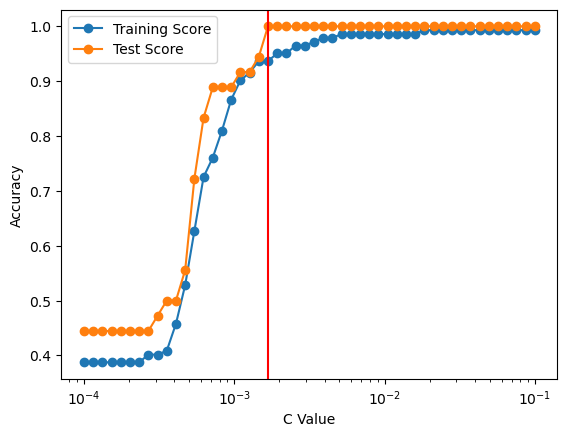

In [29]:
test_scores = []
train_scores = []
for C in np.logspace(-4, -1, 50):
    """Try many different hyperparameters."""
    pipeline = my_fit(C, X_train, y_train)
    test_scores.append([C, pipeline.score(X_test, y_test)]) 
    train_scores.append([C, pipeline.score(X_train, y_train)])
test_scores = np.array(test_scores)
train_scores = np.array(train_scores)

plt.plot(train_scores[:,0], train_scores[:,1], 'o-', label='Training Score')
plt.plot(test_scores[:,0], test_scores[:,1], 'o-', label='Test Score')
plt.xscale('log')
plt.xlabel("C Value")
plt.ylabel("Accuracy")
_ = plt.legend(loc="best")

best_c = test_scores[np.argmax(test_scores[:,1]),0]
plt.axvline(best_c, color='red')

We **could** simply select the best value of C based on the results of the test set above; however, the performance (here 100%) is most likely biased.  We made this selection of C based on this test set, so the results are biased to that specific set of data points.  We can still select this value of C, however, we should expect that 100% is NOT a reasonable estimate of how this model will perform on new unseen data.  To do that, we need to have another set of data that has never been used in any way.

Holdout
---

In the "holdout method", the initial dataset is split twice: once into training and testing, and subsequently the former is split again to yield a validation set.  The training set is used to evaluate model hyperparameters by training on the train set, evaluating on the validation set, then choosing the best hyperparameters based on validation performance.  The final model can be refit on the entire training set (including validation), and its generalization error is estimated based on the held out test data.

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_02.png?raw=true" style="width:500px;">

In [5]:
# First split to get test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    shuffle=True, # Shuffle the data in case there was any bias in the way it was provided
    random_state=0, # Set the random state so the same results always occur
    test_size=0.2
)

# Split again to get validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train,
    shuffle=True,
    random_state=0,
    test_size=0.2
)

In [30]:
print('Breakdown of {} total data points\nTrain: {}\nValidation: {}\nTest: {}'.format(
    X.shape[0],
    X_train.shape[0],
    X_valid.shape[0],
    X_test.shape[0]
    ))

Breakdown of 178 total data points
Train: 142
Validation: 29
Test: 36


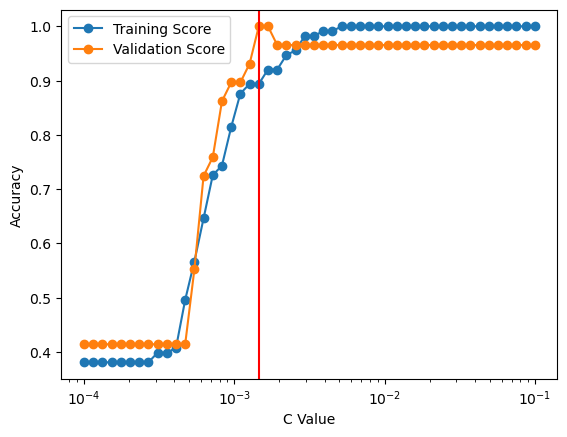

In [7]:
val_scores = []
train_scores = []
for C in np.logspace(-4, -1, 50):
    """Try many different hyperparameters."""
    pipeline = my_fit(C, X_train, y_train)
    val_scores.append([C, pipeline.score(X_valid, y_valid)]) # Evaluate on the validation set
    train_scores.append([C, pipeline.score(X_train, y_train)])
val_scores = np.array(val_scores)
train_scores = np.array(train_scores)

plt.plot(train_scores[:,0], train_scores[:,1], 'o-', label='Training Score')
plt.plot(val_scores[:,0], val_scores[:,1], 'o-', label='Validation Score')
plt.xscale('log')
plt.xlabel("C Value")
plt.ylabel("Accuracy")
_ = plt.legend(loc="best")

best_c = val_scores[np.argmax(val_scores[:,1]),0]
plt.axvline(best_c, color='red')

In [8]:
# Choose C and refit on the training + validation data.

X_t = np.vstack((X_train, X_valid))
y_t = np.concatenate((y_train, y_valid))

final_model = my_fit(C=best_c, X=X_t, y=y_t)

In [9]:
# Now we can evaluate on the test set to estimate how this will perform  in the real world.
print('Final model performance: {}% test, {}% train'.format(
    '%.2f'%(100*final_model.score(X_test, y_test)),
    '%.2f'%(100*final_model.score(X_train, y_train))
))

Final model performance: 94.44% test, 92.04% train


K-Fold and Stratified K-Fold
---

There are 2 problems with the holdout approach.

1. In the case of classification, we might end up with an uneven distribution of classes in the splits above.  In the worst case, all of one class might end up only in the test set and never be trained on!
2. How do we know we made good splits?  Similar to issue (1), if we have a certain distribution of examples in these splits based on those choices, then choosing a different set of splits might result in very different answers.

Issue (1) can be solved with ["stratification"](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) - that is, automatically enforcing that the same fraction of each class ends up in each split we make.  sklearn can conveniently do this for you, and this is only an issue for classification problems.

Issue (2) can be solved by making many splits and simply averaging out the results.  This is called K-fold CV.

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_03.png?raw=true" style="width:500px;">

During each loop, $(k-1)$/$k$ of the data is used to train the model, and the $1/k$ part of the data is kept as the validation set. The validation performance is then averaged across all $k$ different validation sets to get a mean performance for a given model.  This is repeated for all models we wish to test, and the model (set of hyperparameters) with the lowest generalization error is taken.  This is then re-trained on the entire training set; the generalization error is then reported using the held-out test set.

In the limit that only 1 point is held out for testing is called ["Leave One Out CV" (LOOCV)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html).  This is the most computationally expensive form of CV and usually `k` splits are chosen where `k` is usually 3-10. Using smaller $k$ goes faster, but can result in a poorer estimate of model performance if the data between the splits varies significantly.  For smaller datasets increasing $k$ increases the amount of data that goes into training.  

In [10]:
X_dummy = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
y_dummy = np.arange(4)

k = KFold(n_splits=2, shuffle=False)

In [11]:
for train_index, test_index in k.split(X_dummy):
    print(train_index, test_index)
    X_train, X_test = X_dummy[train_index], X_dummy[test_index]
    y_train, y_test = y_dummy[train_index], y_dummy[test_index]

[2 3] [0 1]
[0 1] [2 3]


In [12]:
# The split can also shuffle and randomize X if desired
# Shuffling is actually default in sklearn
k = KFold(n_splits=2, shuffle=True, random_state=42)
for train_index, test_index in k.split(X_dummy):
    print(train_index, test_index)
    X_train, X_test = X_dummy[train_index], X_dummy[test_index]
    y_train, y_test = y_dummy[train_index], y_dummy[test_index]

[0 2] [1 3]
[1 3] [0 2]


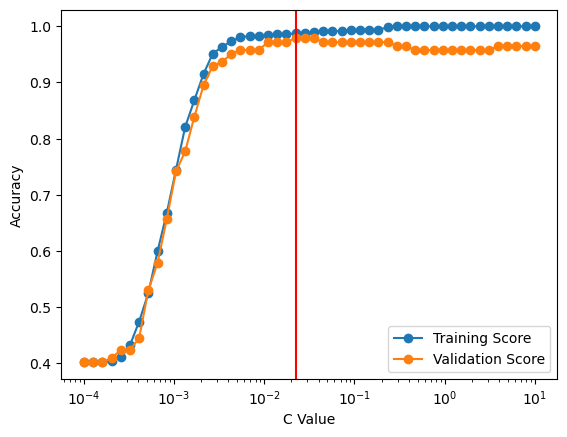

In [13]:
# First, split to get test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    shuffle=True,
    random_state=0, 
    test_size=0.2,
    stratify=y # Now let's stratify our splits based on the distribution naturally found in y
)

# Second, perform k-fold CV on training set
k = KFold(n_splits=10, shuffle=True, random_state=0)

kf_scores = []
for C in np.logspace(-4, 1, 50):
    val_scores = []
    train_scores = []
    for train_index, test_index in k.split(X_train): # Split the training set into k-folds
        X_train_, X_valid_ = X_train[train_index], X_train[test_index]
        y_train_, y_valid_ = y_train[train_index], y_train[test_index]
        pipeline = my_fit(C, X_train_, y_train_)
        val_scores.append(pipeline.score(X_valid_, y_valid_))
        train_scores.append(pipeline.score(X_train_, y_train_))
        
    # Average score over all folds
    kf_scores.append([C, np.mean(val_scores), np.mean(train_scores)])
    
kf_scores = np.array(kf_scores)

plt.plot(kf_scores[:,0], kf_scores[:,2], 'o-', label='Training Score')
plt.plot(kf_scores[:,0], kf_scores[:,1], 'o-', label='Validation Score')
plt.xscale('log')
plt.xlabel("C Value")
plt.ylabel("Accuracy")
_ = plt.legend(loc="best")

best_c = kf_scores[np.argmax(kf_scores[:,1]), 0] # Choose the best C value based on the validation score
plt.axvline(best_c, color='red')

Note how the shape of the curve is much smoother and the optimal value of C is an order of magnitude larger than before! In fact, this improves the model substantially.

In [14]:
# Now retrain on the entire training set.
final_model = my_fit(C=best_c, X=X_train, y=y_train)

# Fourth, report generalization error using test set
print('Final model: {}% test, {}% train'.format(
    '%.2f'%(100*final_model.score(X_test, y_test)),
    '%.2f'%(100*final_model.score(X_train, y_train))
))

Final model: 97.22% test, 98.59% train


Leave Group Out
---

We can also define groups and repeat this process at a "group" level, where groups can be arbitrarily defined. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold) for scikit-learn's example.

This can be helpful if we wish to study create classifiers on the basis of collections and estimate that they generalize well to collections not seen during training.  For example, training on some chemical data that has sets of molecules or atoms and trying to make sure the model can generalize to classes of molecules (e.g., ethers, carboxylic acids, etc.) not used during model fitting.

Pushing it to the limit $k = g$ where $g$ is the number of groups results in [leave one group out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut) CV.

A visualization is also discussed [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators), along with some caveats, such as the fact that folds do not always have the same size.

Optimizing Hyperparameters
---

sklearn has built in functions to do this optimization, and not just on one parameter at a time. At the moment, there are two main approaches: (1) [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), and (2) [RandomizedSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).  (1) is a brute force search over a grid of parameter values.  It has been argued that true optimum rarely fall on regularly chosen grids so (2) random searching can be better.

According to [sklearn's documentation](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search), there are 2 main benefits of (2) over (1):

* A budget can be chosen independent of the number of parameters and possible values.

* Adding parameters that do not influence the performance does not decrease efficiency.

See their [example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) for demonstration.

(1) is the most common approach, though there is good reason to be more preicse if possible. In fact, it is possible to employ other optimization approaches such as Gaussian process optimization to do even better.  There are standard packages such as [auto-sklearn](https://github.com/automl/auto-sklearn), a complete Auto-ML framework, or [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn) that can perform this optimization and are essentially just wrappers around the sklearn package.

In [15]:
pipeline = Pipeline(steps=
                    [
                        ('scaler', CorrectedScaler()),
                        ('lr', LogisticRegression(random_state=0, C=C, max_iter=5000))
                    ]
                   )

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    random_state=42, 
    test_size=0.2
)

<h3>Grid Search</h3>

In [16]:
gs = GridSearchCV(estimator=pipeline,
                  param_grid=
                  [
                      {'lr__C':np.logspace(-5,-1,10),
                       'scaler__with_std':[False]
                      },
                      {'lr__C':np.logspace(-3,2,10),
                       'scaler__with_std':[True]
                      }
                  ], # This can be extended to multiple dicts of parameter grids
                  cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                  n_jobs=-1, # Use all available processors
                  refit=True, # Automatically refit the best model found on the entire training set (default)
                 )

_ = gs.fit(X_train, y_train)

In [17]:
# The best set of hyperparameters is stored here
gs.best_params_

{'lr__C': 2.1544346900318843, 'scaler__with_std': True}

In [18]:
# Detailed CV history can be access like this
gs.cv_results_

{'mean_fit_time': array([0.02102184, 0.02132473, 0.028265  , 0.03493538, 0.04606109,
        0.05974464, 0.05683136, 0.05574141, 0.09550257, 0.1054822 ,
        0.00900283, 0.00858622, 0.00836792, 0.01033745, 0.00881395,
        0.0100841 , 0.01174664, 0.01304245, 0.01321802, 0.01318212]),
 'std_fit_time': array([0.00162635, 0.00159678, 0.00387283, 0.0042335 , 0.00148539,
        0.00552752, 0.00999449, 0.00467312, 0.01257261, 0.0069168 ,
        0.00063602, 0.00074513, 0.00030076, 0.00346086, 0.00023149,
        0.00059612, 0.00098233, 0.00165367, 0.00180151, 0.00246286]),
 'mean_score_time': array([0.00146461, 0.00141387, 0.00141435, 0.00143418, 0.00150275,
        0.00139198, 0.00125036, 0.00103326, 0.00115056, 0.00116377,
        0.00132895, 0.00134354, 0.0013248 , 0.00144892, 0.00130048,
        0.00147023, 0.00133648, 0.00136809, 0.00112596, 0.00115595]),
 'std_score_time': array([1.23197965e-04, 4.93173657e-05, 6.66609820e-05, 5.72648671e-05,
        3.12973768e-05, 5.98394727e-

In [19]:
# Since refit=True, the best model was then retrained on the best hyperparameter set
print('Train set accuracy = {}%\nTest set accuracy = {}%'.format(
    '%.1f'%(100*gs.score(X_train, y_train)),
    '%.1f'%(100*gs.score(X_test, y_test))
))

Train set accuracy = 100.0%
Test set accuracy = 97.2%


<h3>Random Search</h3>

In [20]:
# Look at scipy.stats to see the available distributions.

In [21]:
gs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions= # These are now distributions, not 
    [
        {
            'lr__C':uniform(loc=1.0e-3, scale=1.0e-2),
            'scaler__with_std':[False]
        },
        {
            'lr__C':uniform(loc=5.0, scale=2.0),
            'scaler__with_std':[True]
        }
    ], # This can be extended to multiple dicts of parameter grids
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1, # Use all available processors
    refit=True, # Automatically refit the best model found on the entire training set (default)
    n_iter=30, # Number of parameter settings that are sampled
    random_state=42
)

_ = gs.fit(X_train, y_train)

In [22]:
gs.best_params_

{'lr__C': 5.3119890406724055, 'scaler__with_std': True}

In [23]:
# Slightly different values but identical performance
print('Train set accuracy = {}%\nTest set accuracy = {}%'.format(
    '%.1f'%(100*gs.score(X_train, y_train)),
    '%.1f'%(100*gs.score(X_test, y_test))
))

Train set accuracy = 100.0%
Test set accuracy = 97.2%


Nested CV
---

Until now we have had one number which is our estimate of the model's generalization performance. This is because we has a single held-out test set.  But how do we know that was a "fair" split?  The same uncertainty led us to use K different splits instead of a single test/validation split.  It stands to reason the same logic could be used to solve this problem.  This is the idea behind nested CV.  Instead of 1 held out test set, we repeat the entire K-fold exercise several times, each time with a different test set.  By averaging the test set performance we can get a number (the average performance) and a standard deviation (uncertainty) which can be more insightful.

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/images/06_07.png?raw=true" style="width:500px;">

Importantly, on one outer loop the inner loop will decide the hyperparameters for a model (like C for LogisticRegression), but another loop might find a completely different value for this.  This does not matter.  Ultimately, all we are trying to get here is the final **generalization error estimate** not the best value of the hyperparameters!  Instead, after nested CV is finished, you should perform k-fold CV on the **entire dataset** (instead of doing the initial test/train split) to identify the best hyperparameters unambiguously, then retrain that model on the entire data set to produce the final production model.  

**You simply report the expected performance and uncertainty of that final model as the mean and standard deviation initially found from nested CV.**  This is because the nested CV was meant to simulate what happens when you perform this series of steps (data splitting, hyperparameter tuning, model training) on a fixed dataset.  The final model is just one realization of this scenario which was simulated many times to get an average and uncertainty.

In [63]:
# 1. Let's compare 2 different models/pipelines.

def make_svc(k_inner, random_state_inner=42):
    pipe_svc = Pipeline(steps=[
        ("scaler", CorrectedScaler()),
        ("model", SVC())
    ])
    gs_svc = GridSearchCV(
        estimator=pipe_svc,
        param_grid=[{'model__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}],
        scoring='accuracy',
        cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
            n_splits=k_inner,
            shuffle=True,
            random_state=random_state_inner
        ),
        refit=True
    )
    
    return gs_svc

def make_tree(k_inner, random_state_inner=42):
    gs_tree = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=0),
        param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
        scoring='accuracy',
        cv=sklearn.model_selection.StratifiedKFold( # Since this is a classification problem we will stratify
            n_splits=k_inner,
            shuffle=True,
            random_state=random_state_inner
        ),
        refit=True
    )
    
    return gs_tree

def perform_nested_cv(inner_model, k_outer, random_state_outer=42):
    # cross_val_score is a utility from sklearn that performs CV and returns the test set scores. This
    # is what effectively creates the different test sets
    # By passing a grid search CV object, the inner loop is handled by this object
    scores = cross_val_score(
        inner_model, 
        X_train, 
        y_train, 
        scoring='accuracy', 
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=k_outer,
            shuffle=True,
            random_state=random_state_outer
        )
    )
    
    return scores
    
def compare_pipelines(X_train, y_train):
    """These values need to be the same to make a fair comparison"""
    k_inner = 2
    k_outer = 5
    random_state_inner = 42
    random_state_outer = 0
    
    scores = perform_nested_cv(
        make_svc(k_inner=k_inner, random_state_inner=random_state_inner), 
        k_outer=k_outer, 
        random_state_outer=random_state_outer
    )
    print('%dx%d Nested CV accuracy for SVC: %.3f +/- %.3f' % (k_outer, k_inner, np.mean(scores), np.std(scores)))
    print('Raw scores: {}\n'.format(scores))
    
    scores = perform_nested_cv(
        make_tree(k_inner=k_inner, random_state_inner=random_state_inner), 
        k_outer=k_outer, 
        random_state_outer=random_state_outer
    )
    print('%dx%d Nested CV accuracy for Tree: %.3f +/- %.3f' % (k_outer, k_inner, np.mean(scores), np.std(scores)))
    print('Raw scores: {}\n'.format(scores))

In [64]:
# Each score contains k_outer different scores - in principle, each outer look could have a different set of model
# hyperparameters; but this is ok - we are not building the final model, just trying to see which is a better one
# on average.

compare_pipelines(X_train, y_train)

5x2 Nested CV accuracy for SVC: 0.979 +/- 0.041
Raw scores: [0.89655172 1.         1.         1.         1.        ]

5x2 Nested CV accuracy for Tree: 0.915 +/- 0.043
Raw scores: [0.89655172 0.96551724 0.89285714 0.85714286 0.96428571]



This suggests the SVC pipeline is the better model.  So let's proceed with that model.

In [65]:
# 2. Having made a decision, we should now train the final model.

svc_pipe = make_svc(
    k_inner=10, # We can choose a larger number of splits for a better estimate of optimal hyperparameters here.
    random_state_inner=42
)

# Recall the `refit=True` is specified so after the best hyperparameters are found the model is refit on the entire 
# training set.
_ = svc_pipe.fit(X_train, y_train)

In [68]:
# We can evaluate this model on the held out test to see how it does.
svc_pipe.score(X_test, y_test)

1.0

In [73]:
# However, we do not need to use this estimate.  We already know how the SVC pipeline performes on the "average" test set
# which was given above (97.9 +/- 4.1%).  In a real-world situation, it is common to retrain the model using all the data.

_ = svc_pipe.fit(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))

# This model's performance is then reported as the nested CV performance (97.9 +/- 4.1%) since we have nothing left to 
# test on.